<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/mobilenet_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrained MobileNet
MobileNet has been trained for many applications, including image segmentation, bounding box detection and ImageNet classification. In this notebook, we retrain the smallest version of MobileNet to classify whether an image in our dataset contains a 'person', a 'car' or 'neither.

# Acknowledgements
This was inspired by https://www.tensorflow.org/tutorials/images/transfer_learning (Accessed 29 Oct 2020)

# Code

## Imports
General Setup; GPU setup is under Training.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile
import shutil
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

## Fetch Data
Upload the zip file of our images into '/content/' (i.e. the root of the Colab file directory. Then fetch the data using the code below.

`dataset_X` refers to the dataset you want to use, where `X` is the desired maximum images per category.

In [3]:
# Definitions
dataset ='/content/drive/My Drive/Haptic Vest/dataset_person_car'
classes = ['neither', 'person', None , 'car']
class_ids = [0,1,3]
dataset_types = ['train','dev','test']
all_processed_imgs_dir = '/content/drive/My Drive/Haptic Vest/person_car_other_imgs_processed'

train_ids = np.loadtxt(dataset, dtype=(int, int))
train_ids_dict = dict(train_ids)

x_train_ids, y_train_ids = train_ids[:,0], train_ids[:,1]
assert(x_train_ids.shape == y_train_ids.shape)
x_train_ids[0], y_train_ids[0]
print(f"There are {len(x_train_ids)} images, set(x_train_ids) = {len(set(x_train_ids))} images.")

There are 77650 images, set(x_train_ids) = 77033 images.


In [4]:
######################### 
# CHANGE HERE
######################### 
dataset_extension = '40000'
######################### 

zip_file_path = '/content/processed_subset' + dataset_extension + '.zip'
unzipped_dir = '/content/'
dataset_X = unzipped_dir + 'processed_subset' + dataset_extension
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzipped_dir)

Create sub-folder structure for Tensorflow to load from directory

In [5]:
# In case of problem, pull emergency switch
for dataset_type in dataset_types:
  shutil.rmtree(dataset_X + '/' + dataset_type, ignore_errors=True)

leaf_folders = [list(zip([dataset_types[i]]*3, class_ids)) for i in range(len(dataset_types))]
leaf_folders = [list(zip([dataset_types[i]]*3, class_ids)) for i in range(len(dataset_types))]
subpaths = [dataset_X + '/' + folder[0] + '/' + str(folder[1]) for folder_list in leaf_folders for folder in folder_list ]
for subpath in subpaths:
  os.makedirs(subpath, mode=0o777, exist_ok=False)

# Dataset Creation
These two cells are taken from Phil Pfeffer's implenetation of customnn.ipynb, part of his concurrent CS229 project.

In [6]:
dataset_X_ids = {}
dataset_X_labels = []
for entry in os.scandir(dataset_X):
  if entry.is_dir() or os.path.basename(entry)[0] == '.':
    continue
  id = int(os.path.basename(entry)[:-4])
  dataset_X_ids[id] = train_ids_dict[id]
  dataset_X_labels.append(train_ids_dict[id])

print(len(dataset_X_ids))
print(len(dataset_X_labels))

dev_pct = 0.1
test_pct = 0.05
train_pct = 1 - dev_pct - test_pct
assert (dev_pct + test_pct + train_pct == 1)

num_neither = np.sum(np.array(dataset_X_labels)==0)
num_person = np.sum(np.array(dataset_X_labels)==1)
num_car = np.sum(np.array(dataset_X_labels)==3)
num_class_examples = {0:num_neither, 1:num_person, 3: num_car}
print(num_class_examples, num_neither +num_person + num_car)


num_test = {key: int(test_pct * num_class) for key, num_class in num_class_examples.items()}
num_dev = {key: int(dev_pct * num_class) for key, num_class in num_class_examples.items()}
num_train = {class_id: num_class_examples[class_id] - num_dev[class_id] - num_test[class_id] for class_id in class_ids}

print(num_test, "\n", num_dev, "\n", num_train)

65534
65534
{0: 37585, 1: 25470, 3: 2479} 65534
{0: 1879, 1: 1273, 3: 123} 
 {0: 3758, 1: 2547, 3: 247} 
 {0: 31948, 1: 21650, 3: 2109}


In [7]:
def path_to_id(path):
  return int(os.path.basename(entry)[:-4])

num_test_done = {class_id: 0 for class_id in class_ids}
num_dev_done = {class_id: 0 for class_id in class_ids}
num_train_done = {class_id: 0 for class_id in class_ids}
for idx, entry in enumerate(os.scandir(dataset_X)):
  if entry.is_dir() or os.path.basename(entry)[0] == '.':
    continue
  id = path_to_id(entry)
  label = train_ids_dict[id]
  
  if num_train_done[label] != num_train[label]:
    num_train_done[label] += 1
    shutil.copyfile(entry, dataset_X + '/train/' + str(label) + '/' + os.path.basename(entry))
  elif num_dev_done[label] != num_dev[label]:
    num_dev_done[label] += 1
    shutil.copyfile(entry, dataset_X + '/dev/' + str(label) + '/' + os.path.basename(entry))
  elif num_test_done[label] != num_test[label]:
    num_test_done[label] += 1
    shutil.copyfile(entry, dataset_X + '/test/' + str(label) + '/' + os.path.basename(entry))
  
  if idx % 5000 == 0:
    print(idx, num_train_done, num_dev_done, num_test_done)

print(num_train_done, num_dev_done, num_test_done)

0 {0: 1, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
5000 {0: 2828, 1: 1990, 3: 183} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
10000 {0: 5721, 1: 3914, 3: 366} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
15000 {0: 8613, 1: 5830, 3: 558} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
20000 {0: 11463, 1: 7785, 3: 753} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
25000 {0: 14322, 1: 9732, 3: 947} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
30000 {0: 17232, 1: 11640, 3: 1128} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
35000 {0: 20123, 1: 13552, 3: 1325} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
40000 {0: 22987, 1: 15500, 3: 1513} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
45000 {0: 25811, 1: 17497, 3: 1691} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
50000 {0: 28655, 1: 19440, 3: 1903} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
55000 {0: 31515, 1: 21375, 3: 2108} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
60000 {0: 31948, 1: 21650, 3: 2109} {0: 2402, 1: 1703, 3: 186} {0: 0, 1: 0, 3: 0}
65000 {0: 31948, 1: 21650, 3: 2109} {0: 3758, 1: 2547, 3: 2

# Create Dataloader

In [28]:
BATCH_SIZE = 32
ORIG_IMG_SIZE = (96, 96)
ORIG_COLOR_MODE ='grayscale'
IMG_SIZE = (128,128)
COLOR_MODE = 'rgb'

train_dataset = image_dataset_from_directory(dataset_X +'/train/', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
dev_dataset = image_dataset_from_directory(dataset_X +'/dev/', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
test_dataset = image_dataset_from_directory(dataset_X +'/test/', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)

Found 55707 files belonging to 3 classes.
Found 6552 files belonging to 3 classes.
Found 3275 files belonging to 3 classes.


(128, 128, 3)


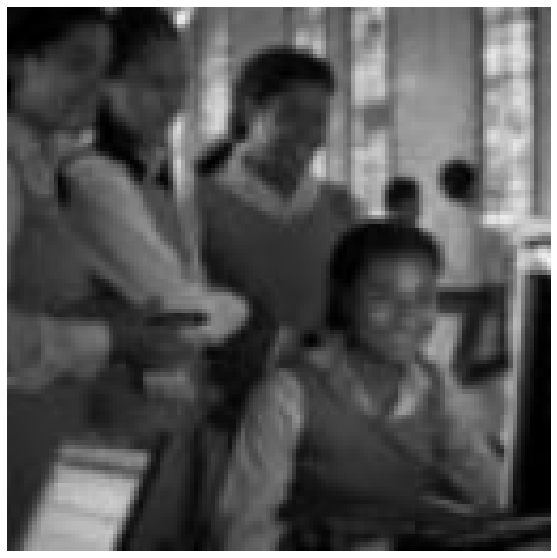

In [48]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  # for i in range(9):
  #   ax = plt.subplot(3, 3, i + 1)
    # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    # plt.imshow(augmented_image[0] / 255)
  plt.imshow(first_image / 255)
  plt.axis('off')
  print(first_image.shape)
  break

In [45]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
dev_dataset = dev_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation
Add data augmentation to all images

In [30]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])

# # convert to 3 channel (RGB)
# x = np.stack((x,)*3, axis=-1) 

# MobileNet Model

In [31]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [32]:
# TODO: Replace this base_model line so that it loads one of the 0.5MB models from 
# https://www.tensorflow.org/lite/guide/hosted_models#image_classification
# instead of whatever this default model is

# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)

#Same syntax for MobileNetV2 and V1
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               alpha=0.25, # just add this
                                               include_top=False,
                                               weights='imagenet')

In [33]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 256)


# GPU Setup

In [34]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [35]:
base_model.trainable = False
base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "mobilenet_0.25_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 8)         216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 8)         32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 8)         0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 8)         72        
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 8)  

In [36]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])

In [38]:
model.summary()
len(model.trainable_variables)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_0.25_128 (Function (None, 4, 4, 256)         218544    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

2

# Training

In [39]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(dev_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

ValueError: ignored

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

# Learning Plot

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

From GOOGLE
Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.